In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


os.chdir('C:/Users/honglin.wang/Documents/ML/talkingdata-mobile-user-demographics')

datadir = './'
gatrain = pd.read_csv(os.path.join(datadir,'gender_age_train.csv'),
                      index_col='device_id')
gatest = pd.read_csv(os.path.join(datadir,'gender_age_test.csv'),
                     index_col = 'device_id')
phone = pd.read_csv(os.path.join(datadir,'phone_brand_device_model.csv'))
# Get rid of duplicate device ids in phone
phone = phone.drop_duplicates('device_id',keep='first').set_index('device_id')
events = pd.read_csv(os.path.join(datadir,'events.csv'),
                     parse_dates=['timestamp'], index_col='event_id')
appevents = pd.read_csv(os.path.join(datadir,'app_events.csv'), 
                        usecols=['event_id','app_id','is_active'],
                        dtype={'is_active':bool})
applabels = pd.read_csv(os.path.join(datadir,'app_labels.csv'))

print('file reading is done!')

file reading is done!


In [2]:
# to calculate feature brand
gatrain['trainrow'] = np.arange(gatrain.shape[0])
gatest['testrow'] = np.arange(gatest.shape[0])

brandencoder = LabelEncoder().fit(phone.phone_brand)
phone['brand'] = brandencoder.transform(phone['phone_brand'])
gatrain['brand'] = phone['brand']
gatest['brand'] = phone['brand']

Xtr_brand = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.brand)))
Xte_brand = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.brand)))
# print(gatrain.head(20))
# print(type(Xtr_brand))
print('Brand features: train shape {}, test shape {}'.format(Xtr_brand.shape, Xte_brand.shape))

Brand features: train shape (74645, 131), test shape (112071, 131)


In [45]:

# print(gatrain.brand)
# print(Xtr_brand.toarray().shape)

In [3]:
# to calculate the feature model
m = phone.phone_brand.str.cat(phone.device_model)
print(m.head())
modelencoder = LabelEncoder().fit(m)
phone['model'] = modelencoder.transform(m)
gatrain['model'] = phone['model']
gatest['model'] = phone['model']
Xtr_model = csr_matrix((np.ones(gatrain.shape[0]),(gatrain.trainrow, gatrain.model)))
Xte_model = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.model)))
print('Model features: train shape {}, test shape {}'.format(Xtr_model.shape, Xte_model.shape))


device_id
-8890648629457979026               小米红米
 1277779817574759137             小米MI 2
 5137427614288105724        三星Galaxy S4
 3669464369358936369          SUGAR时尚手机
-5019277647504317457    三星Galaxy Note 2
Name: phone_brand, dtype: object
Model features: train shape (74645, 1667), test shape (112071, 1667)


In [4]:
appencoder = LabelEncoder().fit(appevents.app_id)
appevents['app'] = appencoder.transform(appevents.app_id)
print(appevents.info())
napps = len(appencoder.classes_)
print(napps)

# print(appevents.merge(events[['device_id']], how='left',left_on='event_id',right_index=True)
#                        .groupby(['device_id','app'])['app'].agg(['size']))

deviceapps = (appevents.merge(events[['device_id']], how='left',left_on='event_id',right_index=True)
                       .groupby(['device_id','app'])['app'].agg(['size'])
                       .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                       .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                       .reset_index())
print(deviceapps.head())

d = deviceapps.dropna(subset=['trainrow'])
Xtr_app = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.app)), 
                      shape=(gatrain.shape[0],napps))
# print(Xtr_app)
d = deviceapps.dropna(subset=['testrow'])
Xte_app = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.app)), 
                      shape=(gatest.shape[0],napps))
print('Apps data: train shape {}, test shape {}'.format(Xtr_app.shape, Xte_app.shape))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32473067 entries, 0 to 32473066
Data columns (total 4 columns):
event_id     int64
app_id       int64
is_active    bool
app          int64
dtypes: bool(1), int64(3)
memory usage: 774.2 MB
None
19237


             device_id   app  size  trainrow  testrow
0 -9222956879900151005   548    18   21594.0      NaN
1 -9222956879900151005  1096    18   21594.0      NaN
2 -9222956879900151005  1248    26   21594.0      NaN
3 -9222956879900151005  1545    12   21594.0      NaN
4 -9222956879900151005  1664    18   21594.0      NaN


Apps data: train shape (74645, 19237), test shape (112071, 19237)


In [5]:
# to calculate feature label
applabels = applabels.loc[applabels.app_id.isin(appevents.app_id.unique())]
applabels['app'] = appencoder.transform(applabels.app_id)
labelencoder = LabelEncoder().fit(applabels.label_id)
applabels['label'] = labelencoder.transform(applabels.label_id)
nlabels = len(labelencoder.classes_)

print(deviceapps.info())
print(applabels.info())
device_app_label = deviceapps[['device_id','app']].merge(applabels[['app','label']]).groupby(['device_id','label'])['app'].agg(['size'])

devicelabels = (deviceapps[['device_id','app']]
                .merge(applabels[['app','label']])
                .groupby(['device_id','label'])['app'].agg(['size'])
                .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                .reset_index())

print(devicelabels.head())

d = devicelabels.dropna(subset=['trainrow'])
Xtr_label = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.label)), 
                      shape=(gatrain.shape[0],nlabels))
d = devicelabels.dropna(subset=['testrow'])
Xte_label = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.label)), 
                      shape=(gatest.shape[0],nlabels))
print('Labels data: train shape {}, test shape {}'.format(Xtr_label.shape, Xte_label.shape))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2369025 entries, 0 to 2369024
Data columns (total 5 columns):
device_id    int64
app          int64
size         int64
trainrow     float64
testrow      float64
dtypes: float64(2), int64(3)
memory usage: 90.4 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 78204 entries, 0 to 459942
Data columns (total 4 columns):
app_id      78204 non-null int64
label_id    78204 non-null int64
app         78204 non-null int64
label       78204 non-null int64
dtypes: int64(4)
memory usage: 3.0 MB
None


             device_id  label  size  trainrow  testrow
0 -9222956879900151005    117     1   21594.0      NaN
1 -9222956879900151005    120     1   21594.0      NaN
2 -9222956879900151005    126     1   21594.0      NaN
3 -9222956879900151005    138     2   21594.0      NaN
4 -9222956879900151005    147     2   21594.0      NaN


Labels data: train shape (74645, 492), test shape (112071, 492)


In [57]:
# print(nlabels)
# print(d.shape[0])
# print(np.ones(d.shape[0]))
# print(devicelabels.shape)
# print(d.shape)
# print(len(d.trainrow))
# print(Xtr_label.shape[1] + Xtr_model.shape[1] + Xtr_app.shape[1] + Xtr_brand.shape[1])
# print(Xtr_model.shape)
# print(Xtr_app.shape)
# print(Xtr_brand.shape)

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
X = [['Male', 1], ['Female', 3], ['Female', 2]]
print(X)
enc.fit(X)
# enc = OneHotEncoder(categorical_features=None, categories=None,handle_unknown='ignore',n_values=None, sparse=True)
print(enc.categories_)
print(enc.transform([['Female', 1],['Male', 4]]).toarray())
print(enc.inverse_transform([[0, 1, 1, 0, 0], [0, 0, 0, 1, 0]]))
print(enc.get_feature_names())

ohe = OneHotEncoder() 
ohe.fit([['A'],['D'],['B']]) 
print(ohe.transform([['B']]).toarray())
print('xx')


[['Male', 1], ['Female', 3], ['Female', 2]]
[array(['Female', 'Male'], dtype=object), array([1, 2, 3], dtype=object)]
[[1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]]
[['Male' 1]
 [None 2]]
['x0_Female' 'x0_Male' 'x1_1' 'x1_2' 'x1_3']
[[0. 1. 0.]]
xx


In [36]:
# Concatenate all features
Xtrain = hstack((Xtr_brand, Xtr_model, Xtr_app, Xtr_label), format='csr')
Xtest =  hstack((Xte_brand, Xte_model, Xte_app, Xte_label), format='csr')
print(Xtr_brand.shape[1]+Xtr_model.shape[1]+Xtr_app.shape[1]+Xtr_label.shape[1])
print('All features: train shape {}, test shape {}'.format(Xtrain.shape, Xtest.shape))

21527
All features: train shape (74645, 21527), test shape (112071, 21527)


parameter C = 0.001000


parameter C = 0.010000


parameter C = 0.100000


parameter C = 1.000000


train done!


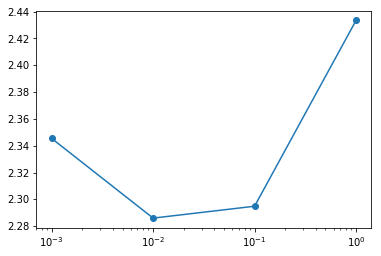

In [8]:

# to do cross validation
targetencoder = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)
nclasses = len(targetencoder.classes_)

def score(clf, y, random_state = 0):
    kf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0],nclasses))
    for itrain, itest in kf.split(Xtrain,y):
        # print('start to train!')
        Xtr, Xte = Xtrain[itrain, :], Xtrain[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        pred[itest,:] = clf.predict_proba(Xte)
        # print("{:.5f}\n".format(log_loss(yte, pred[itest,:])), end=' ')
    
    return log_loss(y, pred)

Cs = np.logspace(-3,0,4)
res = []
for C in Cs:
    print('parameter C = %f' % C)
    res.append(score(LogisticRegression(C = C),y))
print('train done!')
plt.semilogx(Cs, res,'-o')

In [59]:
# from the plot pic, the best C value should be in range (0.01, 1.0), therefore, let's set C = 0.02
best_c = 0.02
lr = LogisticRegression(C = best_c)
print(score(lr,y))

# although LR can handle multipleclass classfication problem, we would take advantage of multinomial to see if there are better performance
lr = LogisticRegression(C = best_c,multi_class='multinomial',solver='lbfgs')
print(score(lr,y))
lr.fit(Xtrain,y)
pred_y = lr.predict_proba(Xtest)
print(pred_y)


2.280714736659567


2.2743779810164813


[[0.00143121 0.00602622 0.01330543 ... 0.12167929 0.25972039 0.39571501]
 [0.00731995 0.01334841 0.03112557 ... 0.07658355 0.23208479 0.20556344]
 [0.0235273  0.03667574 0.03651547 ... 0.10327173 0.18194779 0.13246249]
 ...
 [0.06802983 0.05091064 0.03760672 ... 0.12386035 0.1040735  0.09042311]
 [0.06802983 0.05091064 0.03760672 ... 0.12386035 0.1040735  0.09042311]
 [0.06213059 0.06725585 0.04908115 ... 0.08890525 0.09350414 0.07477696]]
